In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import lightgbm as lgb
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner
from econml.inference import BootstrapInference
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
# ref: https://blog.amedama.jp/entry/lightgbm-cv-model
class ModelExtractionCallback(object):
    """lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス

    NOTE: 非公開クラス '_CVBooster' に依存しているため将来的に動かなく恐れがある
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration

class LGBCV:
    def __init__(self, params, is_stratified):
        self.params = params
        self.is_stratified = is_stratified
    
    def fit(self, X_train, y_train):
        oof = np.zeros(X_train.shape[0])
        extraction_cb = ModelExtractionCallback()
        callbacks = [extraction_cb,]
        lgb_train = lgb.Dataset(X_train, y_train)
        
        lgb.cv(self.params,
                   lgb_train,
                   num_boost_round=1000000,
                   early_stopping_rounds=1000,
                   nfold=5,
                   shuffle=True,
                   stratified=self.is_stratified,
                   seed=42,
                   callbacks=callbacks,
              )
        # コールバックのオブジェクトから学習済みモデルを取り出す
        self.proxy = extraction_cb.boosters_proxy
        self.boosters = extraction_cb.raw_boosters
        self.best_iteration = extraction_cb.best_iteration
        
        return self
    
    def predict(self, X_test):
        y_pred_proba_list = self.proxy.predict(X_test, num_iteration=self.best_iteration)
        y_pred = np.array(y_pred_proba_list).mean(axis=0)
        return y_pred

class LGBCVBinaryClassifier(LGBCV, BaseEstimator, ClassifierMixin):
    def __init__(self):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': 8,
            'num_leaves': 2 ** 8,
            'learning_rate': 0.1,
            'bagging_fraction': 0.8,
            'random_state': 0,
            'num_iterations': 100000000,
            'early_stopping_rounds': 1000,
        }
        super().__init__(params, True)
    
    def _calc_predict_proba(self, X_test):
        y_pred_1 = super().predict(X_test)
        y_pred_0 = 1 - y_pred_1
        y_proba = np.array([y_pred_0, y_pred_1]).T
        return y_proba
        
    def predict(self, X_test):
        y_proba = self._calc_predict_proba(X_test)
        return np.argmax(y_proba, axis=1)
    
    def predict_proba(self, X_test):
        return self._calc_predict_proba(X_test)

class LGBCVRegressor(LGBCV, BaseEstimator, RegressorMixin):
    def __init__(self):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'max_depth': 8,
            'num_leaves': 2 ** 8,
            'learning_rate': 0.1,
            'bagging_fraction': 0.8,
            'random_state': 0,
            'num_iterations': 100000000,
            'early_stopping_rounds': 1000,
        }
        super().__init__(params, False)

In [3]:
# ref: https://github.com/microsoft/EconML/blob/master/notebooks/Metalearners%20Examples.ipynb
# Define DGP
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    """Generates population data for given untreated_outcome, treatment_effect and propensity functions.
    
    Parameters
    ----------
        n (int): population size
        d (int): number of covariates
        controls_outcome (func): untreated outcome conditional on covariates
        treatment_effect (func): treatment effect conditional on covariates
        propensity (func): probability of treatment conditional on covariates
    """
    # Generate covariates
    X = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: np.random.binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

In [4]:
# controls outcome, treatment effect, propensity definitions
def generate_controls_outcome(d):
    beta = np.random.uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + np.random.normal(0, 1)
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

In [5]:
# DGP constants and test data
d = 5
n = 1000
n_test = 250
controls_outcome = generate_controls_outcome(d)
X_test = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

In [6]:
%%time
# Instantiate T learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(models)
# Train T_learner
T_learner.fit(Y, T, X, inference=BootstrapInference(n_bootstrap_samples=10))
# Estimate treatment effects on test data
T_te_gbr = T_learner.effect(X_test)
T_te_gbr_low, T_te_gbr_high = T_learner.effect_interval(X_test, alpha=0.05)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


CPU times: user 1.53 s, sys: 260 ms, total: 1.79 s
Wall time: 812 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [7]:
%%time
# Instantiate T learner
models = LGBCVRegressor()
T_learner = TLearner(models)
# Train T_learner
T_learner.fit(Y, T, X, inference=BootstrapInference(n_bootstrap_samples=10, n_jobs=1))
# Estimate treatment effects on test data
T_te_lgb = T_learner.effect(X_test)
T_te_lgb_low, T_te_lgb_high = T_learner.effect_interval(X_test, alpha=0.05)

Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total u

Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1092 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total used 1123 iterations
Finished loading model, total u

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


CPU times: user 10min 4s, sys: 7.48 s, total: 10min 12s
Wall time: 52.2 s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [8]:
T_te_gbr.mean()

3.906021223002256

In [9]:
T_te_lgb.mean()

3.8000670682008084

In [10]:
np.apply_along_axis(treatment_effect, 1, X_test).mean()

3.84

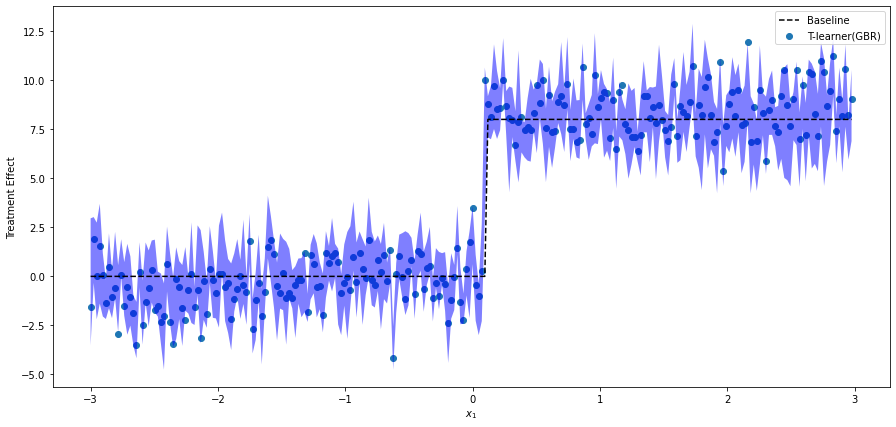

In [11]:
plt.figure(figsize=[15, 7])
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], T_te_gbr, label="T-learner(GBR)")
plt.fill_between(X_test[:, 1], T_te_gbr_low, T_te_gbr_high, facecolor='b', alpha=0.5)

plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()

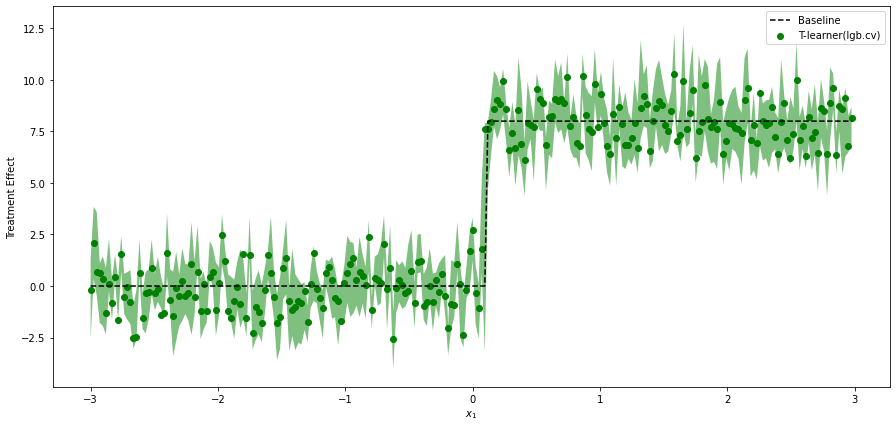

In [12]:
plt.figure(figsize=[15, 7])
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], T_te_lgb, label="T-learner(lgb.cv)", color='g')
plt.fill_between(X_test[:, 1], T_te_lgb_low, T_te_lgb_high, facecolor='g', alpha=0.5)

plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()